# Image with circles
Emiliano Hernández Hurtado & Santiago Pedroza Díaz

In [1]:
import cv2
import wandb
import torch
import numpy as np
import matplotlib.pyplot as plt
from differential_evolution import DE
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from tqdm.notebook import trange, tqdm

In [2]:
run = wandb.init(
    project="de-clip",
    notes="feedling around with differential evolution + clip",
    tag="de-fit-run",
)

wandb: Currently logged in as: santpedrozadiaz. Use `wandb login --relogin` to force relogin


In [3]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [4]:
model = model.to('cuda')

In [5]:
image = Image.open('./monalisa.jpg')

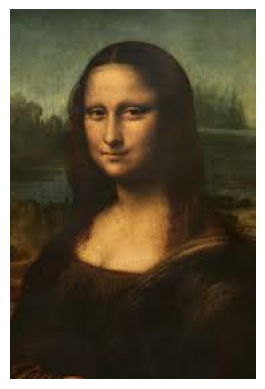

In [6]:
img = cv2.imread('./monalisa.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

In [7]:
img.shape

(275, 183, 3)

In [8]:
def l2(genome, background, img):
    background = background.copy()
    genome = np.abs(genome.astype(int))
    x, y, r, R, G, B = genome
    
    color = (int(R%256),int(G%256),int(B%256))
    res = cv2.circle(background,(x,y), r, color, -1)
    
    fitness = np.sum(cv2.absdiff(img.astype(np.uint8), res.astype(np.uint8)))
   
    return fitness

def cosine_loss(genome, background, text, processor=processor, model=model):
    background = background.copy()
    genome = np.abs(genome.astype(int))
    x, y, r, R, G, B = genome
    r = max(4, r)
    color = (int(R%256),int(G%256),int(B%256))
    res = cv2.circle(background,(x,y), r, color, -1)
    with torch.no_grad():
        image_inputs = processor(images=res, return_tensors="pt")
        text_inputs = processor(text=text, return_tensors="pt")
        image_inputs, text_inputs = image_inputs.to('cuda'), text_inputs.to('cuda')
        image_features = model.get_image_features(**image_inputs)
        text_features = model.get_text_features(**text_inputs)
        
    cosine_similarity = torch.cosine_similarity(image_features, text_features)
    cosine_loss = 1 - cosine_similarity

    return cosine_loss.item()

In [9]:
background = np.zeros(img.shape)

In [10]:
cosine_loss(np.array([194, 86,  20, 239, 199,  52]), background, 'mona lisa')

0.783234715461731

In [ ]:
cosine_loss(np.array([194, 86,  20, 239, 199,  52]), background, 'mona lisa')

In [11]:
bounds = [
    [0, 512],
    [0, 512],
    [1, 25],
    [0, 255],
    [0, 255],
    [0, 255],
]

In [12]:
background = np.zeros(img.shape)

In [13]:
de = DE(cosine_loss, bounds, args=(background, 'mona lisa'), G=200)

In [14]:
ans = de.optimize()

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


In [15]:
ans

array([-209.47439949,  -74.04388052, -218.3430751 , 6255.31543923,
       1590.60953747,  283.79190575])

In [16]:
def show_image(genome, background, figure_number=0, show=False, save=True):
    genome = np.abs(genome.astype(int))
    x, y, r, R, G, B = genome
    color = (int(R%256),int(G%256),int(B%256))
    #r = max(2, r)
    res = cv2.circle(background,(x,y), r, color, -1)
    res = res.astype(np.uint8)
    
    if show:
        plt.figure(figure_number)
        plt.imshow(res)
        plt.axis('off')
        plt.show()
    
    if save:
        filename = f"{figure_number}.png"
        cv2.imwrite(filename, res)
    
    return res

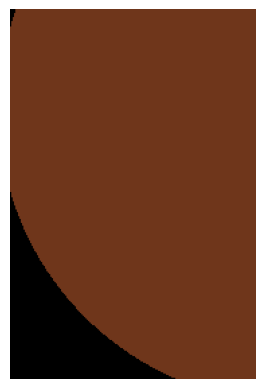

0.745506227016449

In [17]:
show_image(ans, background, show=True, save=False)
cosine_loss(ans, background, 'mona lisa')

In [18]:
fitness_over_time = []

  0%|          | 0/2500 [00:00<?, ?it/s]

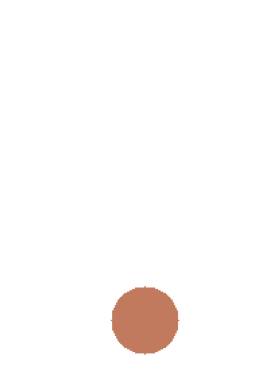

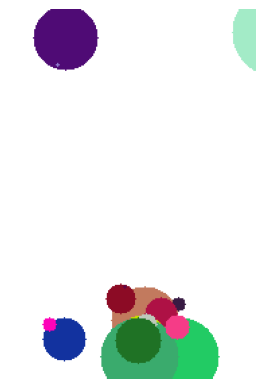

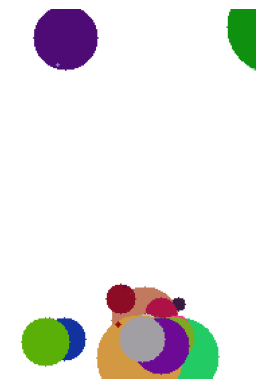

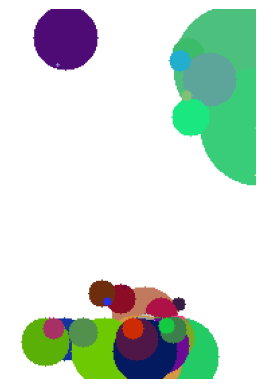

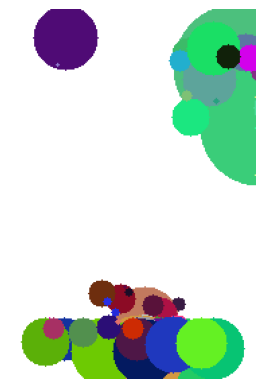

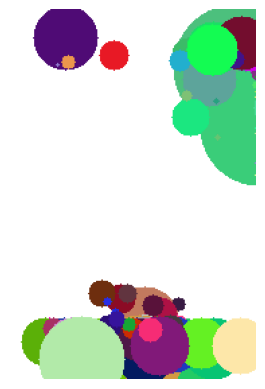

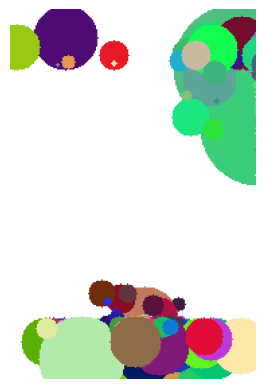

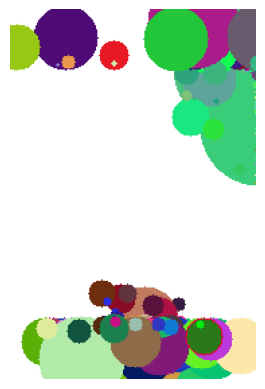

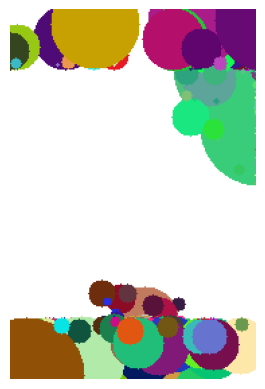

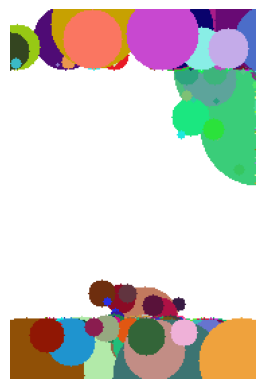

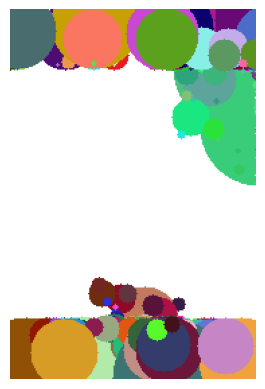

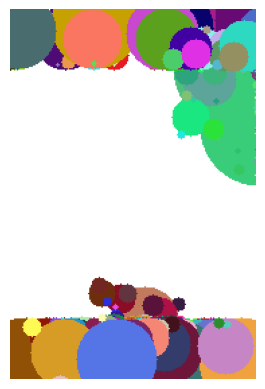

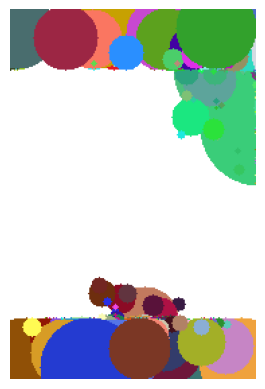

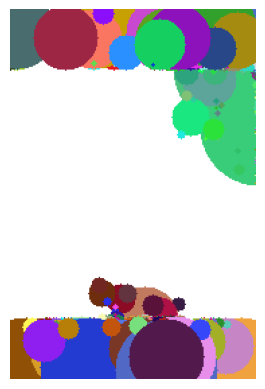

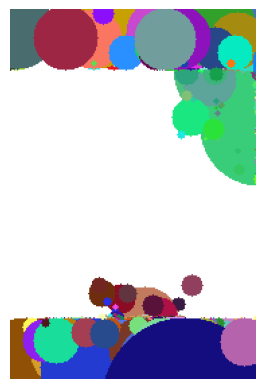

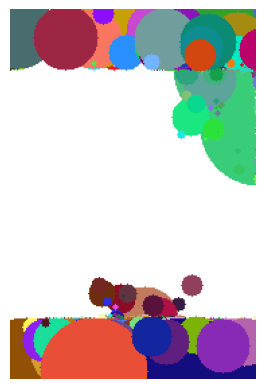

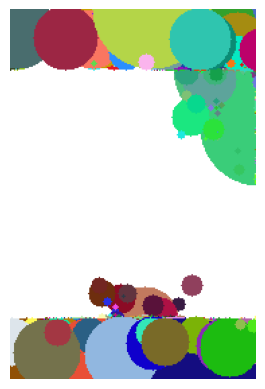

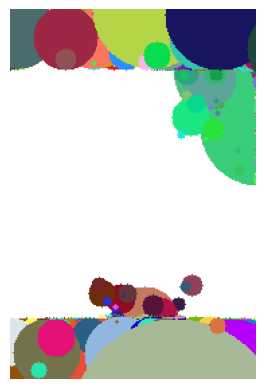

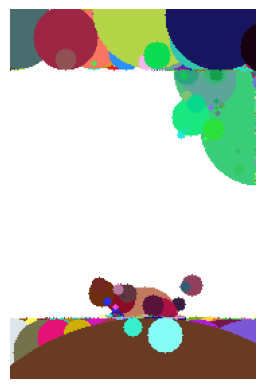

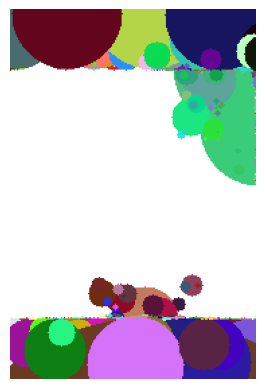

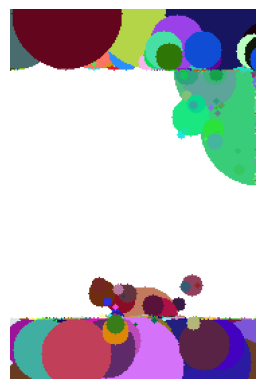

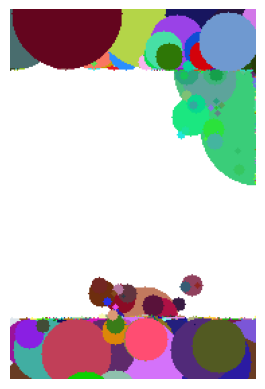

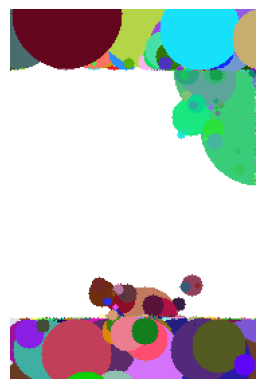

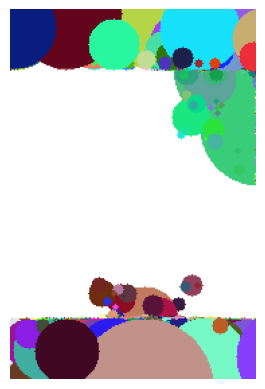

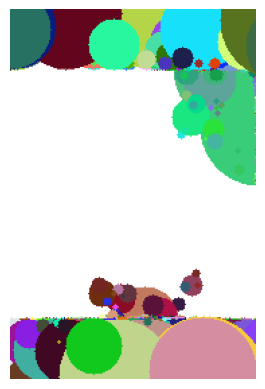

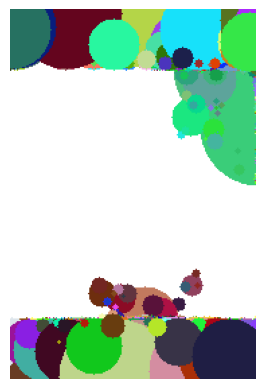

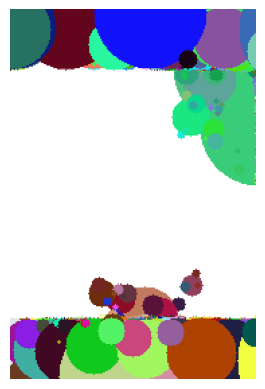

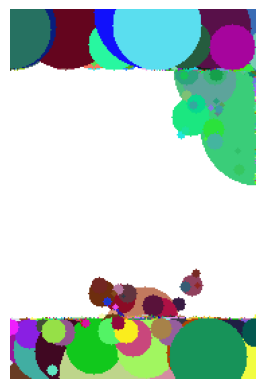

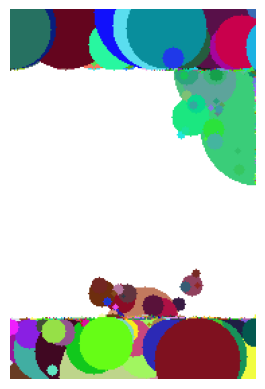

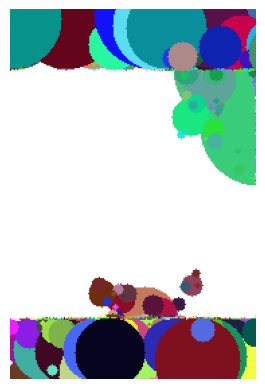

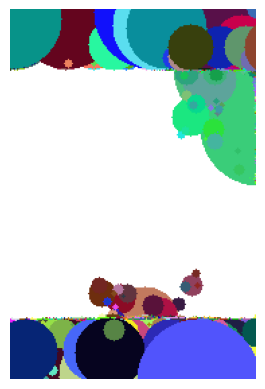

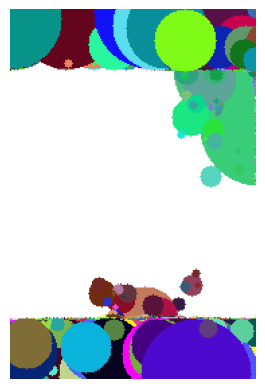

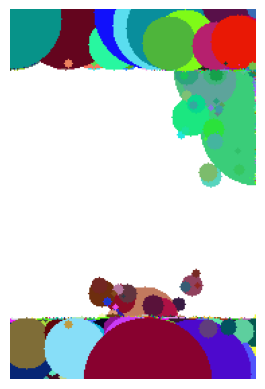

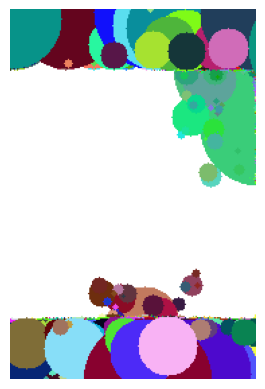

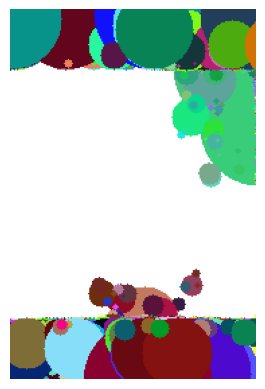

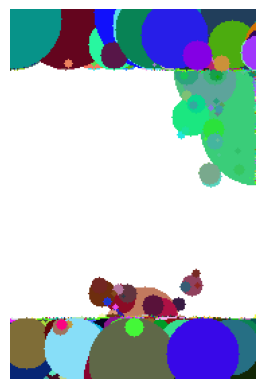

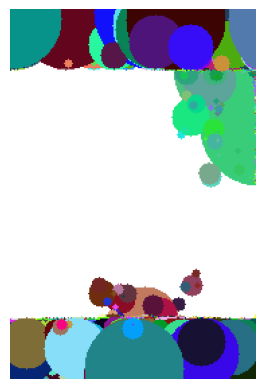

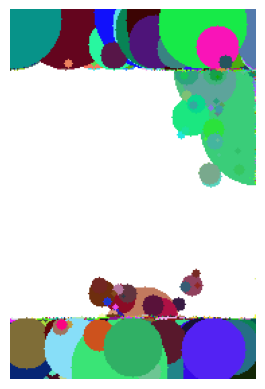

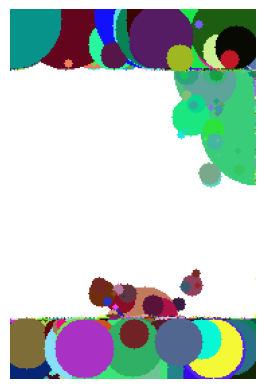

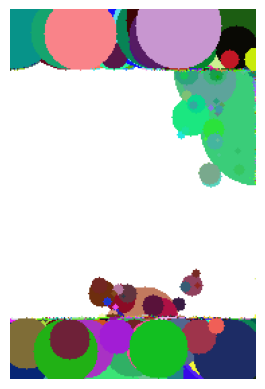

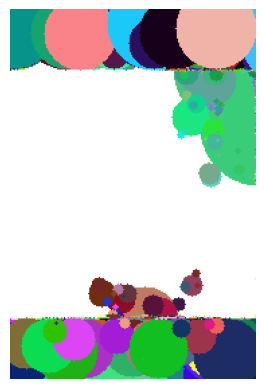

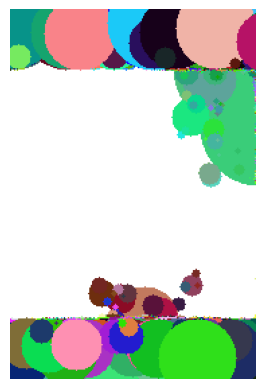

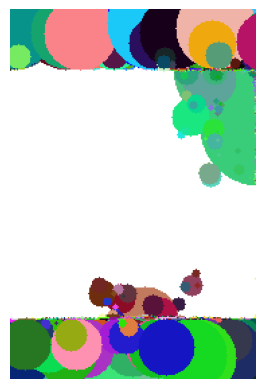

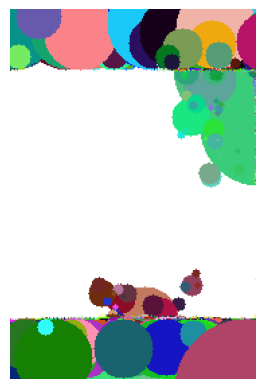

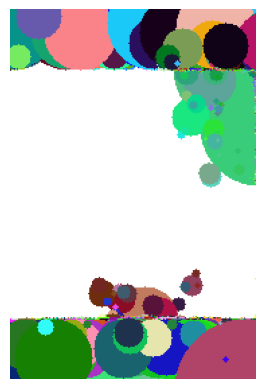

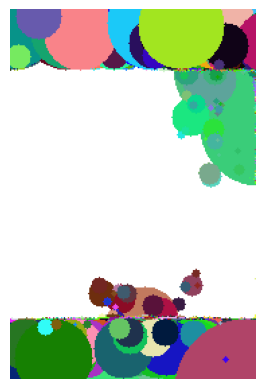

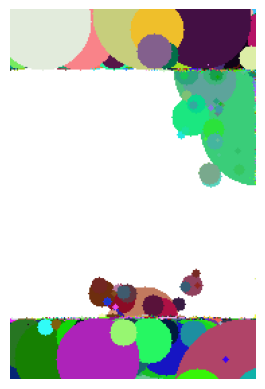

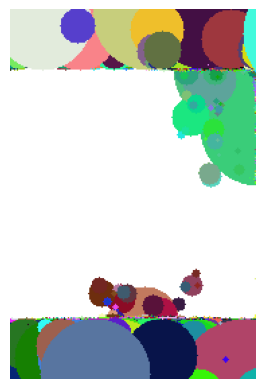

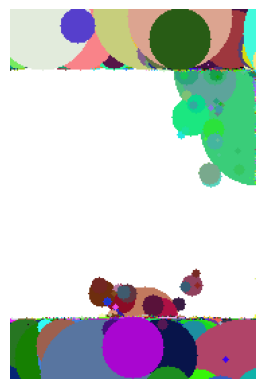

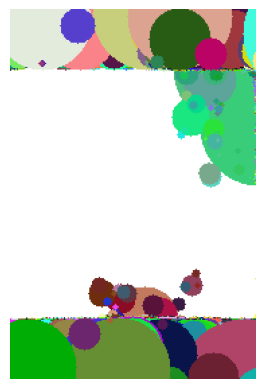

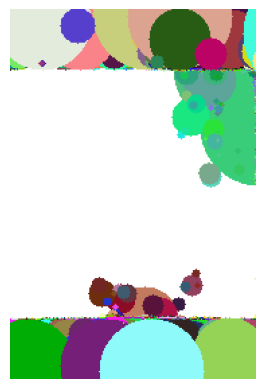

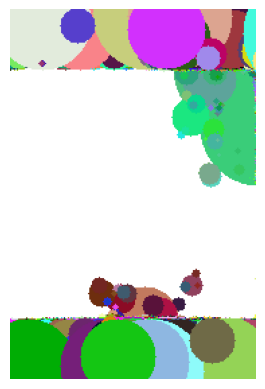

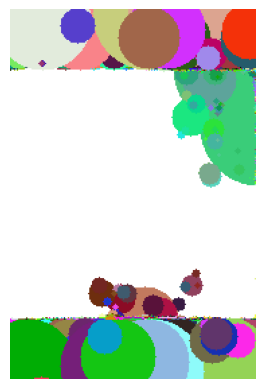

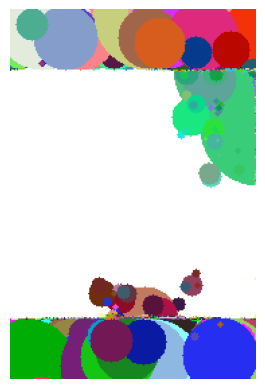

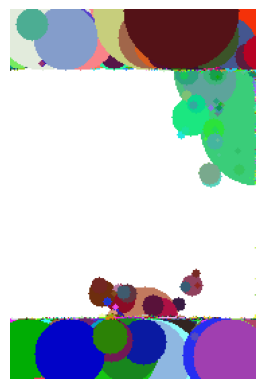

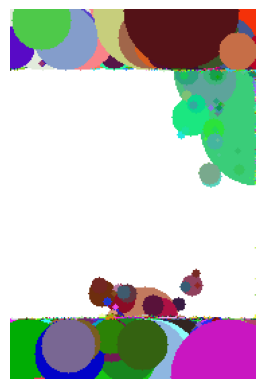

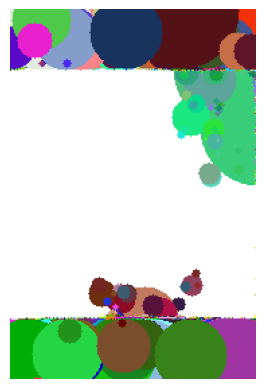

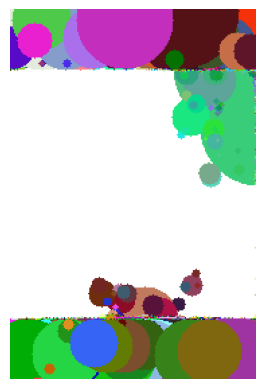

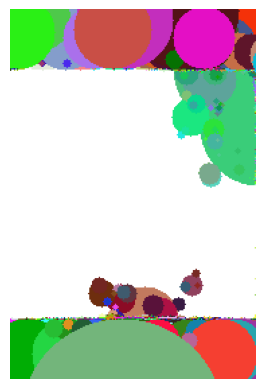

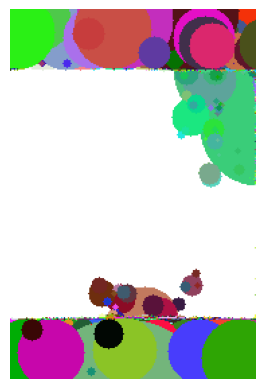

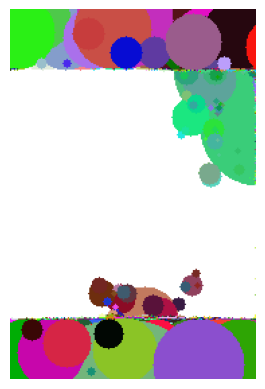

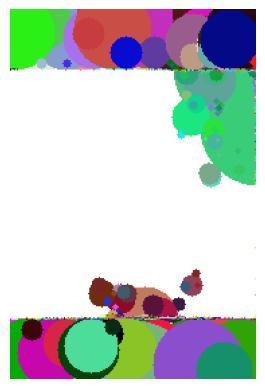

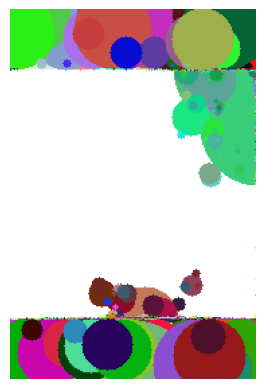

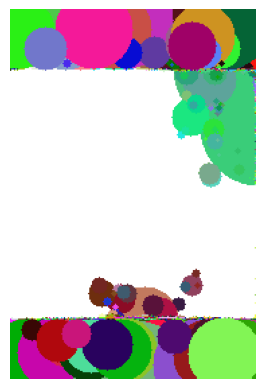

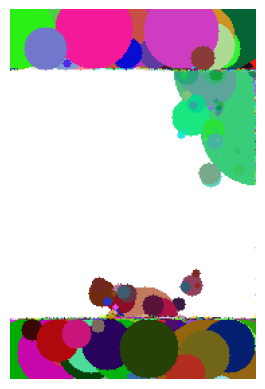

KeyboardInterrupt: 

In [19]:
background = np.ones(img.shape)*255
prompt= 'a drawing of a dog'

for i in trange(2500):
    de = DE(cosine_loss, bounds, args=(background, prompt), G=200)
    ans = de.optimize()
    loss = cosine_loss(ans, background, prompt)
    fitness_over_time.append(loss)
    wandb.log({"cosine_loss": loss})
    
    if i%25 == 0:
        show_image(ans, background, str(i)+prompt, show=True, save=True)
        
    background = show_image(ans, background, str(i)+prompt, show=False, save=False)

In [20]:
wandb.finish()

cosine_loss,█▇▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
cosine_loss,0.6362


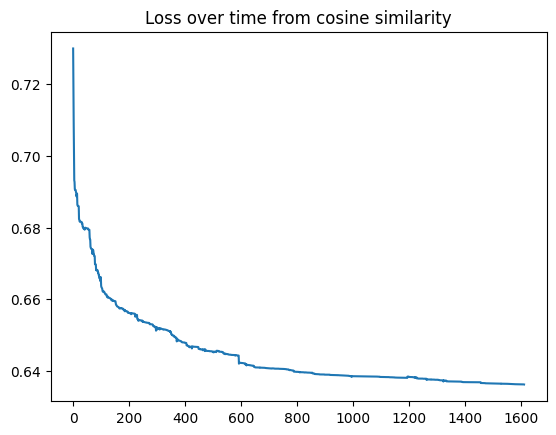

In [21]:
plt.title("Loss over time from cosine similarity")
plt.plot(fitness_over_time)